In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = "/content"
os.chdir(path)

!ls

drive  sample_data


In [ ]:
!mkdir data
# 复制测试集
%cp -av /content/drive/MyDrive/PytorchTest/data/after.rar /content/data

'/content/drive/MyDrive/PytorchTest/data/after.rar' -> '/content/data/after.rar'


In [ ]:
import os
path = "/content/data"
os.chdir(path)
!mkdir wheat-leaf-disease

In [ ]:
# 解压
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/data/after.rar').extractall('/content/data/wheat-leaf-disease')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import os
path = "/content"
os.chdir(path)

!ls

data  drive  sample_data


**导包**

In [ ]:
import os
import time
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

**制作数据集**

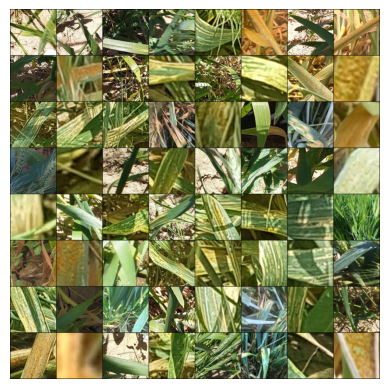

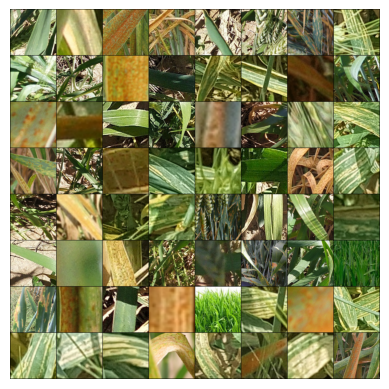

In [ ]:
class_labels = ('Brown_rust', 'Healthy', 'Septoria', 'Yellow_rust')


# 定义数据转换
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


# 生成索引
def make_txt(root, file_name, label):
    global f
    path = os.path.join(root, file_name)

    data = os.listdir(path)
    if 'train' in root:
        f = open(root + '/' + 'train_data.txt', 'a')

    if 'val' in root:
        f = open(root + '/' + 'val_data.txt', 'a')

    for line in data:
        f.write(line + ' ' + str(label) + ' ' + file_name + '\n')
    f.close()


train_path = r'./data/wheat-leaf-disease/after/train'
val_path = r'./data/wheat-leaf-disease/after/val'
for index, value in enumerate(class_labels):
    make_txt(train_path, file_name=value, label=index)
    make_txt(val_path, file_name=value, label=index)


# 读取训练集索引构成DataSet
class WheatLeafBaseDataset(Dataset):
    def __init__(self, img_path, split, transform=None):
        super(WheatLeafBaseDataset, self).__init__()
        self.root = img_path
        self.split = split
        self.txt_root = os.path.join(self.root, self.split, f'{self.split}_data.txt')
        f = open(self.txt_root, 'r')
        data = f.readlines()
        imgs = []
        labels = []
        for line in data:
            line = line.rstrip()
            word = line.split()
            imgs.append(os.path.join(self.root, self.split, word[2], word[0]))
            labels.append(word[1])
        self.img = imgs
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        img = self.img[item]
        label = self.label[item]
        img = Image.open(img).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = np.array(label).astype(np.int64)
        label = torch.from_numpy(label)
        return img, label


class WheatLeafTrainDataset(WheatLeafBaseDataset):
    def __init__(self, img_path, transform=None):
        super(WheatLeafTrainDataset, self).__init__(img_path, 'train', transform)


class WheatLeafValDataset(WheatLeafBaseDataset):
    def __init__(self, img_path, transform=None):
        super(WheatLeafValDataset, self).__init__(img_path, 'val', transform)


path = r'./data/wheat-leaf-disease/after'

train_dataset = WheatLeafTrainDataset(path, transform=transforms)
val_dataset = WheatLeafValDataset(path, transform=transforms)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_data_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True, num_workers=2)


def ShowImage(data_loader):
    for i, data in enumerate(data_loader):
        images, labels = data

        # 打印数据集中的图片
        img = torchvision.utils.make_grid(images).numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.axis("off")
        plt.show()

        break


ShowImage(train_data_loader)
ShowImage(val_data_loader)

In [ ]:
# 计算均值和标准差
mean = torch.zeros(3)
std = torch.zeros(3)

for inputs, _ in train_data_loader:
    mean += inputs.mean(dim=[0, 2, 3], keepdim=True).squeeze()
    std += inputs.std(dim=[0, 2, 3], keepdim=True).squeeze()
mean /= len(train_dataset)
std /= len(train_dataset)

print(f'Mean: {mean.tolist()}')
print(f'Std: {std.tolist()}')

with open('/content/drive/MyDrive/PytorchTest/mean&std/MobileNetV3_large-mean&std.txt', 'w') as file:
    file.write(f'Mean: {mean.tolist()}\n')
    file.write(f'Std: {std.tolist()}\n')

Mean: [0.007634326815605164, 0.007773573976010084, 0.00478956988081336]
Std: [0.0040085576474666595, 0.003831149311736226, 0.003575420007109642]


In [ ]:
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_list = []
acc_list = []

# 数据预处理
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # 随机大小裁剪和缩放
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean, std)  # 标准化
])


In [ ]:
!pip install efficientnet-pytorch

 **在此处修改模型**

In [ ]:
model = models.mobilenet_v3_large(pretrained=True)

**在EfficientNet时候使用这个**

In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=1000)

**冻结模型参数**

In [ ]:
for para in model.parameters():
    para.requires_grad = False

**使用AlexNet、VGG16、DenseNet121时候运行修改模型**

In [ ]:
# 获取原始分类器（classifier）的输入特征数
in_features = model.classifier.in_features

# 修改最后一层全连接层
model.classifier = nn.Linear(in_features, 4)

**使用GoogleNet、ResNet50、EfficientNet_b6时修改模型**

In [ ]:
# 获取原始分类器（fc）的输入特征数
in_features = model.fc.in_features

# 修改最后一层全连接层
model.fc = nn.Linear(in_features, 4)

AttributeError: ignored

**使用MobilenetV3时修改模型**

In [ ]:
# 修改最后一层全连接层
in_features = model.classifier[0].in_features
model.classifier[0] = nn.Linear(in_features, 4)

**将模型移动至GPU**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

**查看模型内存信息**

In [ ]:
num_parameters = sum(p.numel() for p in model.parameters())
size_in_bytes = num_parameters * 4
memory = size_in_bytes / 1024**2
print('Model memory:',memory)

Model memory: 16.238388061523438


In [ ]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        device = next(net.parameters()).device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            net.eval()
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().cpu().item()
            net.train()
            n += y.shape[0]
    return acc_sum / n


def train(net, train_iter, test_iter, optimizer, device, num_epochs):
    sum_time = 0.0

    net = net.to(device)
    print("training on", device)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)
            l = loss_fn(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1

        test_acc = evaluate_accuracy(test_iter, net)

        print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, (train_acc_sum / n) * 100, test_acc * 100, time.time() - start))
        loss_list.append((train_l_sum / batch_count))
        acc_list.append(test_acc)
        sum_time += (time.time() - start)
        torch.save(net.state_dict(), f'/content/drive/MyDrive/PytorchTest/MobileNetV3_largetransfer_learning-wheatleafdiesas_transfer_learningModel.pth')
        # 降低梯度
        scheduler.step(test_acc)

        # 保存 loss_list 到文件
    with open('/content/drive/MyDrive/PytorchTest/Loss_and_acc_result/CNN_loss.txt', 'w') as file:
        for loss in loss_list:
            file.write(str(loss) + '\n')

        # 保存 acc_list 到文件
    with open('/content/drive/MyDrive/PytorchTest/Loss_and_acc_result/CNN_accuracy.txt', 'w') as file:
        for acc in acc_list:
            file.write(str(acc) + '\n')
    with open('/content/drive/MyDrive/PytorchTest/Loss_and_acc_result/CNN_times.txt', 'w') as file:
        file.write(str(sum_time))

**在此处修改训练epochs和下降率**

In [ ]:
lr, num_epochs = 0.001, 30
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=0.00000000001)
train(model, train_data_loader, val_data_loader, optimizer, device, num_epochs)

print('Training and testing completed')

training on cuda:0


TypeError: ignored

In [ ]:
# 获取整个程序执行期间 GPU 内存的最大总量
max_memory = torch.cuda.max_memory_allocated()
print(f"Max GPU Memory Allocated: {max_memory / 1024**3} GB")

Max GPU Memory Allocated: 2.0250415802001953 GB


[0.9834013774991035, 0.5680502228438854, 0.4338479369878769, 0.3549107268452644, 0.3483013093471527, 0.29100567400455474, 0.29766387641429903, 0.2477390192449093, 0.2569425322115421, 0.25374089553952217, 0.26375721357762816, 0.2529954046010971, 0.2582982245832682, 0.25051158033311366, 0.25562017075717447, 0.2606361199170351, 0.30579465851187704, 0.24212724715471268, 0.2499036282300949, 0.2643946405500174, 0.2658116590231657, 0.2516527559608221, 0.2896536201238632, 0.27742915265262125, 0.24271737900562584, 0.26606329493224623, 0.2676188491284847, 0.2754500821232796, 0.24210211746394633, 0.23551040859892963]
[0.63189448441247, 0.7793764988009593, 0.8369304556354916, 0.8621103117505995, 0.8812949640287769, 0.89568345323741, 0.9064748201438849, 0.9184652278177458, 0.9160671462829736, 0.9232613908872902, 0.9232613908872902, 0.9232613908872902, 0.9292565947242206, 0.9304556354916067, 0.9304556354916067, 0.9304556354916067, 0.934052757793765, 0.934052757793765, 0.935251798561151, 0.9340527577

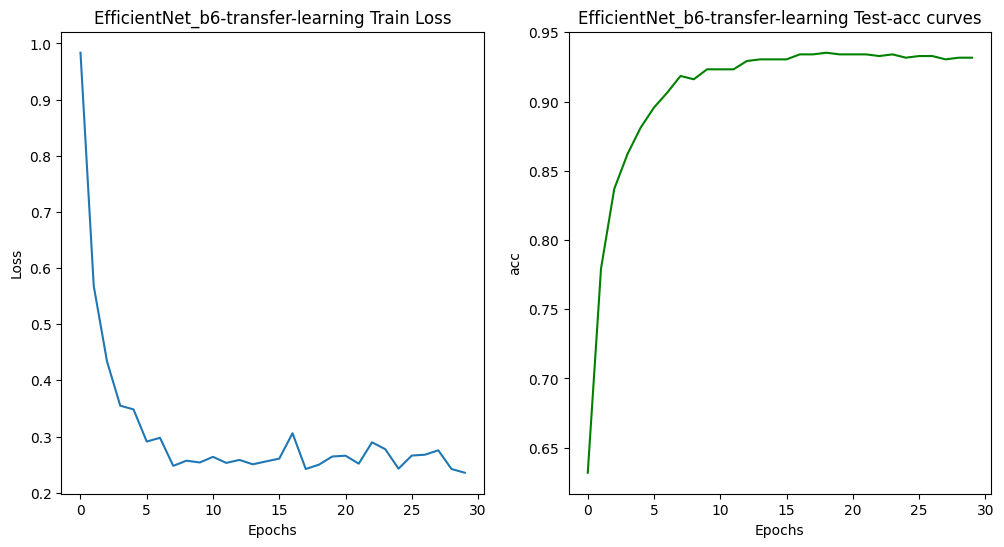

In [ ]:
import matplotlib.pyplot as plt


print(loss_list)
print(acc_list)

plt.figure(figsize=(12, 6))  # 创建一个大图形

# 子图1：损失曲线
plt.subplot(121)
plt.plot(loss_list)
plt.title('MobileNetV3_large-transfer-learning Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 子图2：准确率曲线
plt.subplot(122)
plt.plot(acc_list, color='green')
plt.title('MobileNetV3_large-transfer-learning Test-acc curves')
plt.xlabel('Epochs')
plt.ylabel('acc')

# 保存整个图形为一张图片
plt.savefig('/content/drive/MyDrive/PytorchTest/ResultImg/MobileNetV3_large-transfer-learning.jpg')

plt.show()

释放缓存分配器当前所管理的所有未使用的缓存

In [ ]:
torch.cuda.empty_cache()

**用test集做预测**

In [ ]:
# import torch
# from torch import nn
# from torchvision import transforms, models
# from PIL import Image
# from matplotlib import pyplot as plt
# import os
# import random

# if __name__ == "__main__":
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     transform = transforms.Compose([
#         transforms.Resize([224, 224]),
#         transforms.ToTensor(),
#         transforms.Normalize(mean,
#                   std)
#     ])

#     test_path = r'./data/wheat-leaf-disease/after/test'

#     # 选择两张图片进行测试
#     test_image_paths = []
#     for class_label in class_labels:
#         class_path = os.path.join(test_path, class_label)
#         image_files = os.listdir(class_path)
#         # 从每个子分类中随机选择两张图片
#         selected_images = random.sample(image_files, 2)
#         for image_file in selected_images:
#             test_image_paths.append(os.path.join(class_path, image_file))

#     label_counts = {label: 0 for label in class_labels}

#     my_net = models.vgg16()
#     my_net.classifier[6] = nn.Linear(4096, len(class_labels))  # 调整输出层
#     my_net.load_state_dict(torch.load('/content/drive/MyDrive/PytorchTest/model/VGG16-wheatleafdiesas_RetrainingModel.pth')) #加载模型测试
#     my_net = my_net.to(device)
#     my_net.eval()

#     for image_path in test_path:
#         im = Image.open(image_path)
#         plt.imshow(im)
#         plt.show()
#         im = transform(im)
#         im = torch.unsqueeze(im, dim=0)
#         im = im.to(device)

#         with torch.no_grad():
#             label = my_net(im)
#             pred = label.argmax(dim=1).item()
#             label_counts[class_labels[pred]] += 1

#     total_images = len(test_path)
#     # 计算每个标签的百分比
#     label_percentages = {label: count / total_images * 100 for label, count in label_counts.items()}

#     # 绘制柱状图
#     plt.bar(label_percentages.keys(), label_percentages.values(), color=['blue', 'green', 'red', 'orange'])
#     plt.xlabel('Labels')
#     plt.ylabel('Percentage')
#     plt.title('Percentage of Each Label in Predictions')
#     plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()